In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import re

In [3]:
data_two=pd.read_csv("two bedroom.csv")
data_two.drop('Ambient Temperature',axis=1,inplace=True)

In [4]:
data_two.head()

,Time,Global Solar(kW/m2),PV Cell Temperature(C),Wind Speed(m/s),AC Load(kW)
0,01/01/2007 00:00,0.0,23.72726,2.856398,0.302041
1,01/01/2007 01:00,0.0,23.72726,2.546373,0.277418
2,01/01/2007 02:00,0.0,23.72726,2.334827,0.314410
3,01/01/2007 03:00,0.0,23.72726,0.927367,0.339892
4,01/01/2007 04:00,0.0,23.72726,1.141059,0.379358


In [5]:
#Two rooms
data_two['Month']=data_two['Time'].apply(lambda x:re.search(r'^\d+',x).group(0)).astype(np.int64)
data_two['Day']=data_two['Time'].apply(lambda x:re.search(r'(?<=\/)\d+(?=\/)',x).group(0)).astype(np.int64)
data_two['Hour']=data_two['Time'].apply(lambda x:re.search(r'(^\d+)',x).group(0)).astype(np.int64)
data_two=data_two.drop('Time',axis=1)


In [6]:
train, test, valid=data_two[:6000],data_two[6000:7000],data_two[7000:]

In [7]:
train.shape,test.shape,valid.shape

((6000, 7), (1000, 7), (1760, 7))

In [8]:
#x_train,y_train=x.to_numpy(),y.to_numpy()
x_train,y_train=train.drop('PV Cell Temperature(C)',axis=1).to_numpy(),train['PV Cell Temperature(C)'].to_numpy()
x_val,y_val=valid.drop('PV Cell Temperature(C)',axis=1).to_numpy(),valid['PV Cell Temperature(C)'].to_numpy()
x_test,y_test=test.drop('PV Cell Temperature(C)',axis=1).to_numpy(),test['PV Cell Temperature(C)'].to_numpy()

x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

((6000, 6), (6000,), (1760, 6), (1760,), (1000, 6), (1000,))

In [9]:
scaler=StandardScaler().fit(x_train[:])
def preprocessor(x):
    A=np.copy(x)
    A[: , :]=scaler.transform(A[:,:])
    return A

x_train,x_val,x_test=preprocessor(x_train),preprocessor(x_val),preprocessor(x_test)



# Model Training

In [11]:
from sklearn.metrics import mean_squared_error as mse

In [12]:
#Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

gradB=GradientBoostingRegressor(n_estimators=300).fit(x_train,y_train)
mse(gradB.predict(x_train),y_train,squared=False),mse(gradB.predict(x_val),y_val,squared=False)

(1.2134347247500545, 1.366362306089661)

# Model Testing

In [13]:
mse(gradB.predict(x_test),y_test,squared=False)

1.4709176339621801

In [14]:
prediction=gradB.predict(x_test)

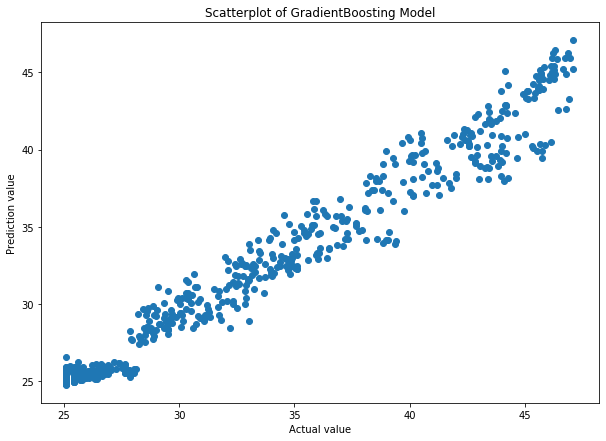

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(y_test,prediction)
plt.xlabel("Actual value")
plt.ylabel("Prediction value")
plt.title("Scatterplot of GradientBoosting Model")
plt.savefig('Scatterplot_two_room.png')

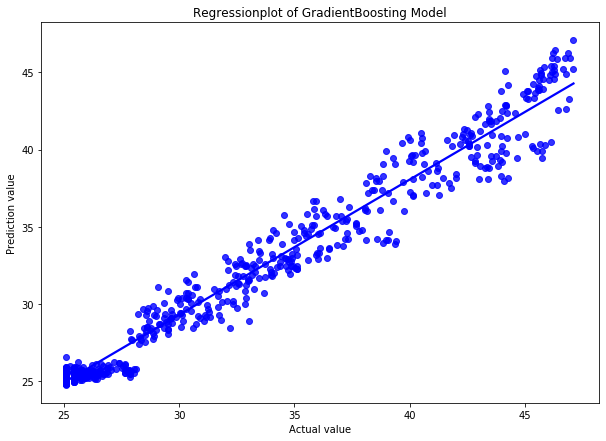

In [16]:
plt.figure(figsize=(10,7))
sns.regplot(x=y_test,y=prediction,ci=None,color='blue')
plt.xlabel("Actual value")
plt.ylabel("Prediction value")
plt.title("Regressionplot of GradientBoosting Model")
plt.savefig('Regressionplot_two_bedrooms.png')

In [17]:
result=pd.DataFrame(x_test)
result['PV Temp']=pd.DataFrame(y_test)
result['Temp Prediction']=pd.DataFrame(prediction)
result.head()


,0,1,2,3,4,5,PV Temp,Temp Prediction
0,-0.741829,-1.222913,-0.573675,1.826488,-0.830103,1.826488,25.11769,25.153740
1,-0.741829,-1.588619,-1.046237,1.826488,-0.830103,1.826488,25.11769,25.112135
2,-0.741829,-1.640577,-1.009695,1.826488,-0.830103,1.826488,25.11769,25.112135
3,-0.741829,-1.561707,-1.170881,1.826488,-0.830103,1.826488,25.11769,25.116045
4,-0.741829,-1.514031,-0.964011,1.826488,-0.830103,1.826488,25.11769,25.116045


In [18]:
result.to_csv("Two Bedrooms Output.csv",index=False)